In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sn


In [5]:
# read csv file into df
churn_raw_df = pd.read_csv('../Resources/telecom_customer_churn.csv')
churn_raw_df.head()

churn_raw_df["Churn Category"].value_counts()


Competitor         841
Dissatisfaction    321
Attitude           314
Price              211
Other              182
Name: Churn Category, dtype: int64

In [7]:
list(churn_raw_df.columns)

['Customer ID',
 'Gender',
 'Age',
 'Married',
 'Number of Dependents',
 'City',
 'Zip Code',
 'Latitude',
 'Longitude',
 'Number of Referrals',
 'Tenure in Months',
 'Offer',
 'Phone Service',
 'Avg Monthly Long Distance Charges',
 'Multiple Lines',
 'Internet Service',
 'Internet Type',
 'Avg Monthly GB Download',
 'Online Security',
 'Online Backup',
 'Device Protection Plan',
 'Premium Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Streaming Music',
 'Unlimited Data',
 'Contract',
 'Paperless Billing',
 'Payment Method',
 'Monthly Charge',
 'Total Charges',
 'Total Refunds',
 'Total Extra Data Charges',
 'Total Long Distance Charges',
 'Total Revenue',
 'Customer Status',
 'Churn Category',
 'Churn Reason']

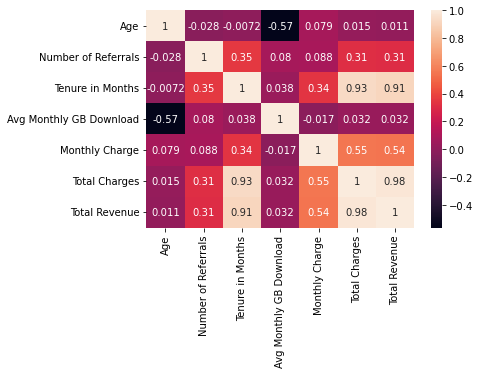

In [8]:
# Feature Selection of Numerical Variables
    # Run a regression on a numerical target?
churn_num_df = churn_raw_df.loc[:, ['Age', 'Number of Referrals', 'Tenure in Months', 'Avg Monthly GB Download', 'Monthly Charge', 'Total Charges', 'Total Revenue']].dropna()
corrmatrix_churn = churn_num_df.corr()
sn.heatmap(corrmatrix_churn, annot=True)
plt.show()


In [9]:
# Feature Selection of Categorical Variables:
    # The idea: use the features that are correlated to the target when training the model

In [10]:
# How gender (feature) is related to customer status (target) 
sex_churn_df = churn_raw_df.loc[(churn_raw_df["Customer Status"] == "Stayed") | (churn_raw_df["Customer Status"] == "Churned"), ["Customer Status", "Gender"]]

# Sex vs Churn Contingency Table
    # Frequency Distribution of sex and customer status
sex_churn = sex_churn_df.groupby(["Gender", "Customer Status"])["Customer Status"].count().unstack()
sex_churn.loc['Total']= sex_churn.sum(numeric_only=True, axis=0)
sex_churn.loc[:,'Total'] = sex_churn.sum(numeric_only=True, axis=1)
sex_churn

# Interpretation:
# Sex of customer alone does not influence churn status

Customer Status,Churned,Stayed,Total
Gender,,,
Female,939,2338,3277
Male,930,2382,3312
Total,1869,4720,6589


In [11]:
# How marriage status (feature) is related to customer status (target)
marriage_df = churn_raw_df.loc[(churn_raw_df["Customer Status"] == "Stayed") | (churn_raw_df["Customer Status"] == "Churned"), ["Married", "Customer Status"]]

# Marriage vs Churn Contingency Table
    # Frequency Distribution of marital status and customer status
marriage_churn = marriage_df.groupby(["Married", "Customer Status"])["Customer Status"].count().unstack()
marriage_churn.loc['Total']= marriage_churn.sum(numeric_only=True, axis=0)
marriage_churn


Customer Status,Churned,Stayed
Married,,
No,1200,2071
Yes,669,2649
Total,1869,4720


In [12]:
# How to determine whether two categorical columns in the dataset are correlated
    # chi-square is a way to check the relationship between two categorical nominal variables
    # The key idea behind the chi-square test is to compare the observed values in the  data to the expected values and see if they are related or not.

# Null Hypothesis: Marriage status and customer status are independent (uncorrelated)

# Alternate Hypothesis: Marriage status and customer status are dependent (correlated)

# Chi-Squared Function
def chi2_function(contingency_table, col1, col2):    
    #---calculate degree of freedom---
    degree_f = (contingency_table.shape[0]-1) * (contingency_table.shape[1]-1)

    #---create the expected value dataframe---
    df_exp = contingency_table.copy()    
    df_exp.iloc[:,:] = np.multiply.outer(contingency_table.sum(1)
        .values,contingency_table.sum().values) / contingency_table.sum().sum()            
    print('---Expected (E)---')
    display(df_exp)

    # calculate chi-square values
    df_chi2 = ((contingency_table - df_exp)**2) / df_exp    
    df_chi2.loc[:,'Total']= df_chi2.sum(axis=1)
    df_chi2.loc['Total']= df_chi2.sum()
    print('---Chi-Square---')
    display(df_chi2)

    #---get chi-square score---   
    chi_square_score = df_chi2.iloc[:-1,:-1].sum().sum()
    
    #---calculate the p-value---
    p = stats.distributions.chi2.sf(chi_square_score, degree_f)
    return chi_square_score, degree_f, p

In [13]:
# Call chi2_function:
chi2_function(marriage_churn, marriage_df["Married"], marriage_df["Customer Status"])

# Interpretation:
# P > 0.05, Marriage status and customer status are independent (uncorrelated).


---Expected (E)---


Customer Status,Churned,Stayed
Married,,
No,927.834117,2343.165883
Yes,941.165883,2376.834117
Total,1869.000000,4720.000000


---Chi-Square---


Customer Status,Churned,Stayed,Total
Married,,,
No,79.835680,31.612900,111.448579
Yes,78.704795,31.165098,109.869893
Total,158.540475,62.777997,221.318472


(221.3184719445054, 2, 8.735835462946832e-49)

In [14]:
# Contract vs customer status

In [15]:
# Payment Method

In [16]:
# Tenure in months (bins transfromation) vs customer status

In [17]:
# Made referal (binary transformation) vs customer status

In [18]:
# Has dependents (binary transformation) vs customer status

In [19]:
# Phone Service

In [20]:
# Internet Type